# Global AI Adoption Patterns: Automation vs Augmentation

Analysis of Claude.ai usage patterns across emerging and developed markets using Anthropic's Economic Index dataset.

**Data Source:** [Anthropic Economic Index](https://huggingface.co/datasets/Anthropic/EconomicIndex) (September 2025 Release)

**Date Range:** August 4-11, 2025

## Setup & Data Loading

In [4]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

# Set paths (relative)
DATA_PATH = Path("../data/intermediate")
OUTPUT_PATH = Path("../outputs")
FIGURES_PATH = Path("../figures")

# Create output directories if they don't exist
OUTPUT_PATH.mkdir(exist_ok=True)
FIGURES_PATH.mkdir(exist_ok=True)

# Load data
print("Loading data...")
df_claude = pd.read_csv(DATA_PATH / "aei_raw_claude_ai_2025-08-04_to_2025-08-11.csv")
df_countries = pd.read_csv(DATA_PATH / "iso_country_codes.csv")
df_gdp = pd.read_csv(DATA_PATH / "gdp_2024_country.csv")

print(f"Claude.ai data: {df_claude.shape[0]:,} rows")
print(f"Countries: {df_countries.shape[0]} codes")
print(f"GDP data: {df_gdp.shape[0]} countries")

Loading data...
Claude.ai data: 100,062 rows
Countries: 252 codes
GDP data: 174 countries


## Data Exploration

In [5]:
print("Claude.ai Data Columns:")
print(df_claude.columns.tolist())
print(f"\nUnique geographies: {df_claude['geography'].unique()}")
print(f"Unique facets: {df_claude['facet'].unique()}")
print(f"\nSample rows:")
df_claude.head()

Claude.ai Data Columns:
['geo_id', 'geography', 'date_start', 'date_end', 'platform_and_product', 'facet', 'level', 'variable', 'cluster_name', 'value']

Unique geographies: ['country' 'global' 'state_us']
Unique facets: ['collaboration' 'country' 'onet_task' 'request'
 'onet_task::collaboration' 'request::collaboration' 'state_us']

Sample rows:


,geo_id,geography,date_start,date_end,platform_and_product,facet,level,variable,cluster_name,value
0,AD,country,2025-08-04,2025-08-11,Claude AI (Free and Pro),collaboration,0,collaboration_count,not_classified,25.0
1,AD,country,2025-08-04,2025-08-11,Claude AI (Free and Pro),collaboration,0,collaboration_pct,not_classified,62.5
2,AD,country,2025-08-04,2025-08-11,Claude AI (Free and Pro),collaboration,0,collaboration_count,task iteration,15.0
3,AD,country,2025-08-04,2025-08-11,Claude AI (Free and Pro),collaboration,0,collaboration_pct,task iteration,37.5
4,AD,country,2025-08-04,2025-08-11,Claude AI (Free and Pro),country,0,usage_count,NaN,40.0


## Classification: Automation vs Augmentation

We classify AI usage patterns into two categories:
- **Automation:** Directive, task execution, script generation (AI does the work)
- **Augmentation:** Feedback loops, iteration, learning, validation (AI assists human work)

In [6]:
# Map ISO codes to country names
iso_to_country = dict(zip(df_countries['iso_alpha_2'], df_countries['country_name']))
df_claude['country_name'] = df_claude['geo_id'].map(iso_to_country)

# Define classification patterns
AUTOMATION_PATTERNS = ['directive', 'none', 'direct execution', 'script generation', 'automation']
AUGMENTATION_PATTERNS = ['feedback loop', 'task iteration', 'learning', 'validation', 'explain', 'debug']

def classify_interaction(cluster_name):
    """Classify cluster as automation, augmentation, or other."""
    if pd.isna(cluster_name):
        return 'other'
    cluster_lower = str(cluster_name).lower()
    
    for pattern in AUTOMATION_PATTERNS:
        if pattern in cluster_lower:
            return 'automation'
    
    for pattern in AUGMENTATION_PATTERNS:
        if pattern in cluster_lower:
            return 'augmentation'
    
    return 'other'

df_claude['interaction_type'] = df_claude['cluster_name'].apply(classify_interaction)

print("Interaction type distribution:")
print(df_claude['interaction_type'].value_counts())

Interaction type distribution:
interaction_type
other           72266
augmentation    19794
automation       8002
Name: count, dtype: int64


## Calculate Automation Rates by Country

In [7]:
# Filter to collaboration facet
df_collab = df_claude[df_claude['facet'] == 'collaboration'].copy()
df_collab['country_name'] = df_collab['country_name'].astype(str).str.strip().str.title()
df_collab = df_collab[df_collab['country_name'].notna()]

# Calculate metrics by country
country_metrics = df_collab.groupby('country_name').agg(
    total_usage=('value', 'sum'),
    automation_volume=('value', lambda x: x[df_collab.loc[x.index, 'interaction_type'] == 'automation'].sum())
).reset_index()

country_metrics['automation_rate'] = (
    country_metrics['automation_volume'] / country_metrics['total_usage'] * 100
).round(1)

country_metrics['augmentation_rate'] = 100 - country_metrics['automation_rate']

# Clean up
country_metrics = country_metrics[country_metrics['total_usage'] > 0]
country_metrics = country_metrics[country_metrics['country_name'] != 'Nan']
country_metrics = country_metrics.sort_values('total_usage', ascending=False)

print("TOP 20 COUNTRIES BY USAGE:")
print("=" * 60)
print(country_metrics[['country_name', 'automation_rate', 'augmentation_rate', 'total_usage']].head(20).to_string(index=False))

TOP 20 COUNTRIES BY USAGE:
  country_name  automation_rate  augmentation_rate  total_usage
 United States             44.8               55.2     208300.0
        Canada             50.1               49.9      73243.0
         India             46.1               53.9      70995.0
        Brazil             55.9               44.1      35582.0
         Japan             37.3               62.7      35398.0
   South Korea             36.8               63.2      35385.0
United Kingdom             36.7               63.3      30574.0
       Germany             35.3               64.7      25787.0
        France             38.0               62.0      21414.0
     Australia             37.8               62.2      18853.0
     Indonesia             47.0               53.0      18837.0
        Israel             37.9               62.1      18065.0
         Italy             37.7               62.3      14483.0
      Colombia             41.6               58.4      13075.0
      Thailan

## Emerging vs Developed Markets Comparison

In [8]:
# Define market classifications
EMERGING_MARKETS = [
    'Brazil', 'India', 'China', 'Mexico', 'Indonesia', 'Turkey', 
    'South Africa', 'Nigeria', 'Kenya', 'Egypt', 'Pakistan',
    'Philippines', 'Vietnam', 'Thailand', 'Colombia', 'Argentina',
    'Chile', 'Poland', 'Malaysia', 'Peru', 'Bangladesh'
]

DEVELOPED_MARKETS = [
    'United States', 'United Kingdom', 'Germany', 'France', 'Japan',
    'Canada', 'Australia', 'Singapore', 'South Korea', 'Netherlands',
    'Sweden', 'Switzerland', 'Denmark', 'Norway', 'Finland',
    'Belgium', 'Austria', 'Italy', 'Spain', 'New Zealand', 'Israel'
]

def calculate_weighted_average(data):
    """Calculate volume-weighted automation rate."""
    if data.empty or data['total_usage'].sum() == 0:
        return 0.0
    return (data['automation_volume'].sum() / data['total_usage'].sum()) * 100

# Calculate weighted averages
emerging_data = country_metrics[country_metrics['country_name'].isin(EMERGING_MARKETS)]
developed_data = country_metrics[country_metrics['country_name'].isin(DEVELOPED_MARKETS)]

emerging_rate = calculate_weighted_average(emerging_data)
developed_rate = calculate_weighted_average(developed_data)
difference = emerging_rate - developed_rate

print("MARKET COMPARISON (Volume-Weighted):")
print("=" * 60)
print(f"Emerging Markets: {emerging_rate:.1f}% automation rate")
print(f"  Countries: {len(emerging_data)}")
print(f"\nDeveloped Markets: {developed_rate:.1f}% automation rate")
print(f"  Countries: {len(developed_data)}")
print(f"\nDifference: {difference:.1f} percentage points")

MARKET COMPARISON (Volume-Weighted):
Emerging Markets: 46.2% automation rate
  Countries: 20

Developed Markets: 41.9% automation rate
  Countries: 20

Difference: 4.2 percentage points


## Visualizations

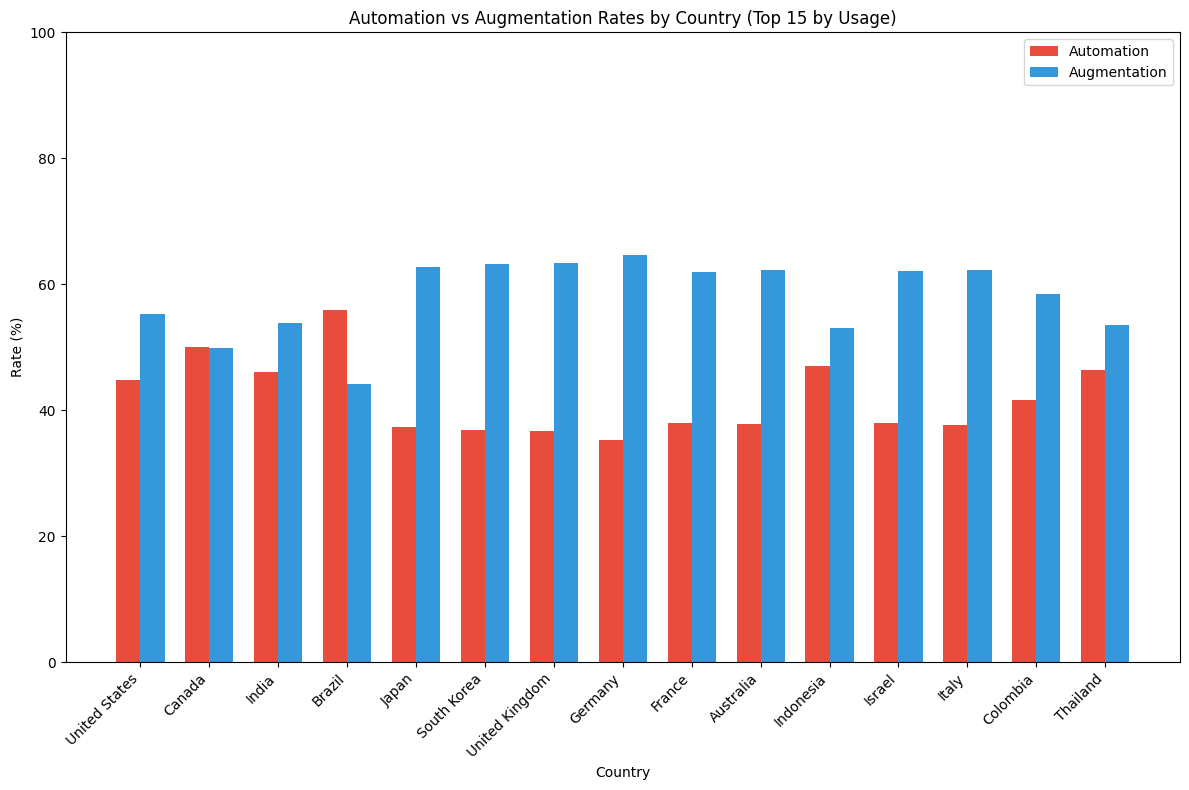

Saved: ../figures/automation_vs_augmentation.png


In [9]:
import matplotlib.pyplot as plt

# Top 15 countries bar chart
top_15 = country_metrics.head(15).copy()

fig, ax = plt.subplots(figsize=(12, 8))
x = range(len(top_15))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], top_15['automation_rate'], width, label='Automation', color='#e74c3c')
bars2 = ax.bar([i + width/2 for i in x], top_15['augmentation_rate'], width, label='Augmentation', color='#3498db')

ax.set_xlabel('Country')
ax.set_ylabel('Rate (%)')
ax.set_title('Automation vs Augmentation Rates by Country (Top 15 by Usage)')
ax.set_xticks(x)
ax.set_xticklabels(top_15['country_name'], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'automation_vs_augmentation.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_PATH / 'automation_vs_augmentation.png'}")

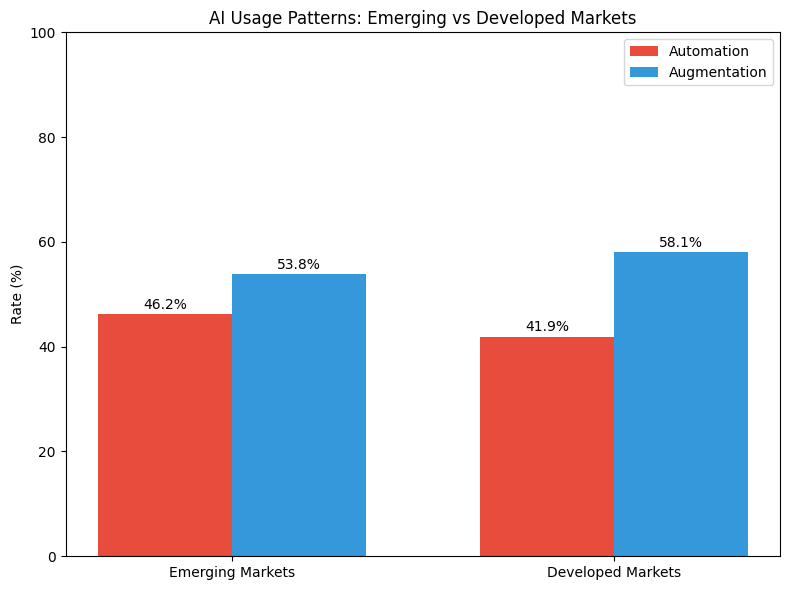

Saved: ../figures/emerging_vs_developed.png


In [10]:
# Emerging vs Developed comparison
fig, ax = plt.subplots(figsize=(8, 6))

markets = ['Emerging Markets', 'Developed Markets']
automation_rates = [emerging_rate, developed_rate]
augmentation_rates = [100 - emerging_rate, 100 - developed_rate]

x = range(len(markets))
width = 0.35

ax.bar([i - width/2 for i in x], automation_rates, width, label='Automation', color='#e74c3c')
ax.bar([i + width/2 for i in x], augmentation_rates, width, label='Augmentation', color='#3498db')

ax.set_ylabel('Rate (%)')
ax.set_title('AI Usage Patterns: Emerging vs Developed Markets')
ax.set_xticks(x)
ax.set_xticklabels(markets)
ax.legend()
ax.set_ylim(0, 100)

# Add value labels
for i, (auto, aug) in enumerate(zip(automation_rates, augmentation_rates)):
    ax.text(i - width/2, auto + 1, f'{auto:.1f}%', ha='center', fontsize=10)
    ax.text(i + width/2, aug + 1, f'{aug:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'emerging_vs_developed.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_PATH / 'emerging_vs_developed.png'}")

## Export Results

In [11]:
# Save country-level results
country_metrics.to_csv(OUTPUT_PATH / 'country_automation_rates.csv', index=False)
print(f"Saved: {OUTPUT_PATH / 'country_automation_rates.csv'}")

# Save summary statistics
summary = pd.DataFrame({
    'metric': ['Emerging Markets Automation Rate', 'Developed Markets Automation Rate', 'Difference (pp)'],
    'value': [f'{emerging_rate:.1f}%', f'{developed_rate:.1f}%', f'{difference:.1f}']
})
summary.to_csv(OUTPUT_PATH / 'summary_statistics.csv', index=False)
print(f"Saved: {OUTPUT_PATH / 'summary_statistics.csv'}")

print("\n" + "=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)

Saved: ../outputs/country_automation_rates.csv
Saved: ../outputs/summary_statistics.csv

ANALYSIS COMPLETE
